# Evaluation of the final CNN model

The original final evaluation was misleading as the ealry stopping parameter had been used incorrectly. This notebook fixes this issue.

The model was chosen in 7_CNN_model_comparison.ipynb and the hyperparameters chosen from 8_CNN_hyperparameter.ipynb.
The early stopping patience to use was decided using notebook 9.

First the model is trained on subjects A, B, D, E, F.
The model is then evaluated on the test subject C. Up until this point the model has not been exposed to this data.

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [1]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
#     !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/doppler_spectrograms_without_corrupt/3/'

RESULTS_PATH = BASE_PATH + 'results/CNN_final_model_evaluation_without_corrupt/'
HYPERPARAMETER_PATH = BASE_PATH + 'results/CNN_hyperparameter_search/'
MODEL_PATH = BASE_PATH + 'models/CNN_final_model_evaluation/'

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
    
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Import remaining packages

In [2]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
# ! pip install scikit-optimize
!pip install git+https://GitHub.com/scikit-optimize/scikit-optimize/
from skopt import load

  Cloning https://GitHub.com/scikit-optimize/scikit-optimize/ to /tmp/pip-req-build-1y1tj_qu
  Stored in directory: /tmp/pip-ephem-wheel-cache-dicv5iiw/wheels/92/86/bd/160b895e1a04fb3aaba6e6d6d958603f09b1cbaf9d4266b893
Successfully built scikit-optimize


In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup

In [0]:
SAVE_RESULTS_TEST_C = False
SAVE_GRAPHS_TEST_C = True

SAVE_RESULTS_20 = False
SAVE_GRAPHS_20 = True

SAVE_RESULTS_6_FOLD = False
SAVE_GRAPHS_6_FOLD = True

In [0]:
# Patience chosen from notebook 9
nb_epoch = 100
# nb_epoch = 1 #testing
patience = 7

In [0]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

# input image dimensions
img_rows, img_cols = 75, 75

users = ["A", "B", "C", "D", "E", "F"] 

In [0]:
def load_data(user_letter):
    with open(DATA_PATH + user_letter + "_data.pkl", 'rb') as data_file:
        data = pickle.load(data_file)
        data = data.reshape(data.shape[0], 1, 75, 75)
        
    with open(DATA_PATH + user_letter + "_labels.pkl", 'rb') as labels_file:
        labels = pickle.load(labels_file)
        labels = np.reshape(labels, (len(labels), 1))

        
    return data, labels

In [0]:
datasets = {}
for user in users:
    data, labels = load_data(user)
    datasets[user] = {"data":data, "labels":labels}

## Define Model

In [0]:
def make_model(nb_filters, img_rows, img_cols, nb_classes, activation,
               dropout, num_dense_nodes, num_dense_layers,
               kernel_size, pooling_size):
    
    kernel_size = (kernel_size, kernel_size)
    pooling_size = (pooling_size, pooling_size)
    
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, kernel_size, padding='same', input_shape=(1, img_rows, img_cols), activation=activation))
    model.add(Convolution2D(size_1, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Convolution2D(size_2, kernel_size, padding='same', activation=activation))
    model.add(Convolution2D(size_2, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Flatten())
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

## Train Model Function

In [0]:
def train_model(train_data, train_labels, test_data, test_labels, hyperparameters, epochs, patience):
    parameters = hyperparameters
    model = make_model("8-16", img_rows, img_cols, nb_classes, parameters[2],
               parameters[3], parameters[4], parameters[5],
               parameters[6], parameters[7])
    
    optimizer = parameters[0] 
    learning_rate = parameters[1]
    if optimizer == 'adam':
        selected_optimizer = Adam(lr=learning_rate)

    elif optimizer == 'sgd_standard':
        selected_optimizer = SGD(lr=learning_rate)

    else:
        # nestrov momentum
        selected_optimizer = SGD(lr=learning_rate, decay=1e-6, momentum=0.9,
                                 nesterov=True)

    model.compile(loss='categorical_crossentropy',
                  optimizer=selected_optimizer,
                  metrics=['accuracy'])
    
    callback_list = []
    if patience != -1:
        early_stopping = EarlyStopping(monitor='val_acc', patience=patience)
        callback_list.append(early_stopping)
        
    history = model.fit(train_data, train_labels,
                        batch_size=parameters[8],
                        epochs=epochs,
                        shuffle=True, 
                        validation_data=(test_data, test_labels),
                        callbacks=callback_list,
                        verbose=0)
    
    return history, model

## Evaluate Model function

In [0]:
def evaluate_model(model, test_data, test_labels, batch_size, target_names):
    evaluation = model.evaluate(test_data, test_labels,
                                batch_size=batch_size, verbose=1)

    loss = evaluation[0]
    accuracy = evaluation[1]

    test_pred = model.predict_classes(test_data)
    report = classification_report(np.argmax(test_labels,axis=1),
                                   test_pred, target_names=target_names)
    conf_matrix = confusion_matrix(np.argmax(test_labels,axis=1), test_pred)
    return {
        "loss": loss,
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": conf_matrix
    }

### Load hyperparameter results

In [0]:
# needed for loading results (objective needs to be defined)
def objective():
    return 0

In [14]:
dimensions = ['optimizer', 'learning_rate', 'activation', 'dropout',
              'num_dense_nodes', 'num_dense_layers', 'kernel_size',
              'pooling_size', 'batch_size']

res_gp = load(HYPERPARAMETER_PATH + "res_gp_complete.pkl")
parameters = res_gp.x

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
for index, parameter in enumerate(parameters):
    print(dimensions[index] + ":", parameter)

optimizer: adam
learning_rate: 0.0012375685948764468
activation: relu
dropout: 0.597428888669298
num_dense_nodes: 1024
num_dense_layers: 3
kernel_size: 3
pooling_size: 2
batch_size: 576


# Evaluating on subject C

In [0]:
def split_train_validation_test(test_user, total_folds=5, validation_fold=0):
    # split by user then action
    labels = np.arange(0, 7)
    actions = {}
    for user in users:
        actions[user] = {}
        for label in labels:
            actions[user][str(label)] = []
        
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        for index, label in enumerate(labels):
            actions[user][str(label[0])].append(data[index])
        
    # convert to numpy array
    labels = np.arange(0, 7)
    for user in users:
        for label in labels:
            actions[user][str(label)] = np.array(actions[user][str(label)])
            
    train_labels = []
    train_data = []
    validation_labels = []
    validation_data = []
    test_labels = []
    test_data = []
    # each user A->F
    for user in users:
        # 0 -> 6
        for label in labels:            
            if user == test_user:
                testing_data = actions[user][str(label)]
                testing_labels = np.full(testing_data.shape[0], label)
                test_data.append(testing_data)
                test_labels.append(testing_labels)  
                
            else:
                # for example, if using 5 folds splits data into 5 subsets
                split_actions = np.array_split(actions[user][str(label)], total_folds)
                training_data = []
                validating_data = []
                for fold in range(total_folds):
                    if fold == validation_fold:
                        validating_data.append(split_actions[fold])
                    else:
                        training_data.append(split_actions[fold])

                training_data = np.concatenate(training_data, axis=0)
                training_labels = np.full(training_data.shape[0], label)
                validating_data = np.concatenate(validating_data, axis=0)
                validating_labels = np.full(validating_data.shape[0], label)

                train_data.append(training_data)
                train_labels.append(training_labels)
                validation_data.append(validating_data)
                validation_labels.append(validating_labels)   
            
    train_labels = np.concatenate(train_labels, axis=0)
    train_data = np.concatenate(train_data, axis=0)
    validation_labels = np.concatenate(validation_labels, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    test_labels = np_utils.to_categorical(test_labels, nb_classes)
    
    train_data = train_data.astype('float32')/255
    validation_data = validation_data.astype('float32')/255
    test_data = test_data.astype('float32')/255
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels,
        "test_data": test_data,
        "test_labels": test_labels
       }

## Train Model

In [0]:
data_split = split_train_validation_test("C") # subject c is test subject

# 80% of each subject (excluding C)
train_data = data_split["train_data"]
train_labels = data_split["train_labels"]

# 20% taken from each subject (excluding C)
validation_data = data_split["validation_data"]
validation_labels = data_split["validation_labels"]

# subject C
test_data = data_split["test_data"]
test_labels = data_split["test_labels"]

In [0]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(28301, 1, 75, 75)
(7088, 1, 75, 75)
(7966, 1, 75, 75)


In [0]:
history, model = train_model(train_data, train_labels,
                             validation_data, validation_labels,
                             parameters, nb_epoch, patience)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Evaluate Model

In [0]:
results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
results["history"] = history.history

7966/7966 [==============================] - 1s 138us/step


## Save Results

In [0]:
if SAVE_RESULTS_TEST_C:
    with open(RESULTS_PATH + "results_test_c.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_test_c.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Visualize Results

In [0]:
print("Accuracy:",results["accuracy"]*100)

Accuracy: 69.93472267567978


### Accuracy

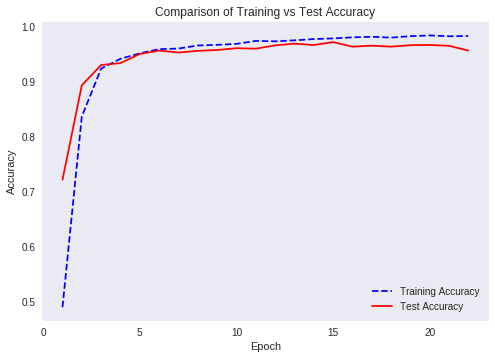

In [0]:
training_acc = results["history"]['acc']
test_acc = results["history"]['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'b--')
plt.plot(epoch_count, test_acc, 'r-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Comparison of Training vs Test Accuracy")
plt.grid()
if SAVE_GRAPHS_TEST_C:
    plt.savefig(RESULTS_PATH + "training_vs_test_acc.pdf", format='pdf')
plt.show()

### Loss

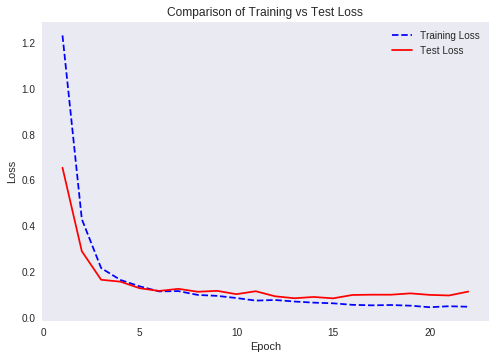

In [0]:
training_loss = results["history"]['loss']
test_loss = results["history"]['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b--')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Comparison of Training vs Test Loss")
plt.grid()
if SAVE_GRAPHS_TEST_C:
    plt.savefig(RESULTS_PATH + "training_vs_test_loss.pdf", format='pdf')
plt.show()

### Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, classes, save=False, path='/'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save:
        plt.savefig(path, format='pdf')
    plt.show()

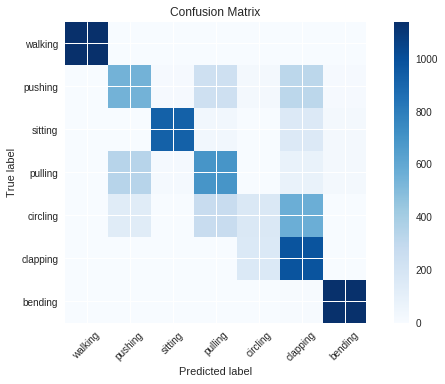

In [0]:
plot_confusion_matrix(results["confusion_matrix"], target_names,
                      save=SAVE_GRAPHS_TEST_C, path=RESULTS_PATH + "confusion_matrix.pdf")

In [0]:
K.clear_session()

# Evaluating on subset of the data (all subjects) 5-Fold
use 60% for training, 20% for validation (early stopping) and the final 20% for testing.

In [0]:
# pass in percentage to make test set
# fold = 0,1,2,3,4
def split_data(test_fold, validation_fold, total_folds):
    # split by user then action
    labels = np.arange(0, 7)
    actions = {}
    for user in users:
        actions[user] = {}
        for label in labels:
            actions[user][str(label)] = []
        
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        for index, label in enumerate(labels):
            actions[user][str(label[0])].append(data[index])        
        
    labels = np.arange(0, 7)
    for user in users:
        for label in labels:
            actions[user][str(label)] = np.array(actions[user][str(label)])
            
    train_labels = []
    train_data = []
    validation_labels = []
    validation_data = []
    test_labels = []
    test_data = []
    # each user A->F
    for user in users:
        # 0 -> 6
        for label in labels:
            # for example, if using 5 folds splits data into 5 subsets
            split_actions = np.array_split(actions[user][str(label)], total_folds)
            training_data = []
            validating_data = []
            testing_data = []
            for fold in range(total_folds):
                if fold == test_fold:
                    testing_data.append(split_actions[fold])
                    
                elif fold == validation_fold:
                    validating_data.append(split_actions[fold])
                    
                else:
                    training_data.append(split_actions[fold])
                    
            training_data = np.concatenate(training_data, axis=0)
            training_labels = np.full(training_data.shape[0], label)
            validating_data = np.concatenate(validating_data, axis=0)
            validating_labels = np.full(validating_data.shape[0], label)
            testing_data = np.concatenate(testing_data, axis=0)
            testing_labels = np.full(testing_data.shape[0], label)
            
            train_data.append(training_data)
            train_labels.append(training_labels)
            validation_data.append(validating_data)
            validation_labels.append(validating_labels)
            test_data.append(testing_data)
            test_labels.append(testing_labels)   
            
    train_labels = np.concatenate(train_labels, axis=0)
    train_data = np.concatenate(train_data, axis=0)
    validation_labels = np.concatenate(validation_labels, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    test_labels = np_utils.to_categorical(test_labels, nb_classes)
    
    train_data = train_data.astype('float32')/255
    validation_data = validation_data.astype('float32')/255
    test_data = test_data.astype('float32')/255
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels,
        "test_data": test_data,
        "test_labels": test_labels
       }

In [0]:
k_fold_results = {}
number_of_folds = 5
for fold in range(number_of_folds):
    k_fold_results[str(fold)] = {}

In [19]:
average_accuracy = 0
average_loss = 0
for fold in range(number_of_folds):
    test_fold = fold
    validation_fold = (test_fold + 1) % number_of_folds
    print("Fold:", fold)
    
    data_split = split_data(test_fold, validation_fold, number_of_folds)
    
    train_data = data_split["train_data"]
    train_labels = data_split["train_labels"]
    validation_data = data_split["validation_data"]
    validation_labels = data_split["validation_labels"]
    test_data = data_split["test_data"]
    test_labels = data_split["test_labels"]

    history, model = train_model(train_data, train_labels,
                                 validation_data, validation_labels,
                                 parameters, nb_epoch, patience)
    
    results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
    average_accuracy += results["accuracy"]
    average_loss += results["loss"]
    k_fold_results[str(fold)]["accuracy"] = results["accuracy"]
    k_fold_results[str(fold)]["loss"] = results["loss"]
    
k_fold_results["average_accuracy"] = average_accuracy/number_of_folds
k_fold_results["average_loss"] = average_loss/number_of_folds

Fold: 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
8684/8684 [==============================] - 1s 94us/step
Fold: 1
8684/8684 [==============================] - 1s 96us/step
Fold: 2
8684/8684 [==============================] - 1s 95us/step
Fold: 3
8654/8654 [==============================] - 1s 96us/step
Fold: 4
8649/8649 [==============================] - 1s 96us/step


## Save Results

In [0]:
if SAVE_RESULTS_20:
    with open(RESULTS_PATH + "results_test_20.pkl", 'wb') as results_file:
        pickle.dump(k_fold_results, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_test_20.pkl", 'rb') as results_file:
    k_fold_results = pickle.load(results_file)

## Visualize Results

In [22]:
print("Average Accuracy:", k_fold_results["average_accuracy"]*100)
print("Average Loss:", k_fold_results["average_loss"])

Average Accuracy: 94.95711698203738
Average Loss: 0.17136900369661043


### Accuracy Fold Distribution

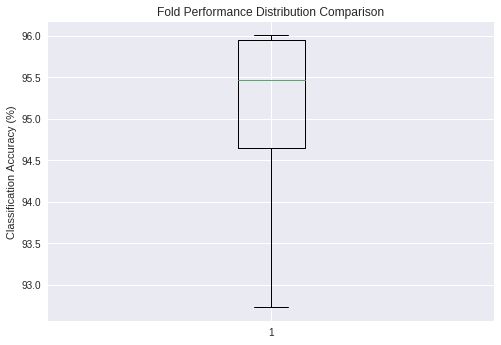

In [23]:
accuracies = []
for fold in range(number_of_folds):
    accuracies.append(k_fold_results[str(fold)]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
# plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_20:
     plt.savefig(RESULTS_PATH + "boxplot_20.pdf", format='pdf')

In [0]:
K.clear_session()

# Six-Fold Cross-Validation
Same method as employed when comparing the original model except this time user all users.

In [0]:
results_six_fold = {}
for user in users:
    results_six_fold[user] = {}

In [26]:
average_accuracy = 0
average_loss = 0
for user in users:
    data_split = split_train_validation_test(user)
    train_data = data_split["train_data"]
    train_labels = data_split["train_labels"]
    validation_data = data_split["validation_data"]
    validation_labels = data_split["validation_labels"]
    test_data = data_split["test_data"]
    test_labels = data_split["test_labels"]
    
    history, model = train_model(train_data, train_labels, validation_data, validation_labels, parameters, nb_epoch, patience)
    
    results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
    average_accuracy += results["accuracy"]
    average_loss += results["loss"]
    results_six_fold[user]["accuracy"] = results["accuracy"]
    results_six_fold[user]["loss"] = results["loss"]

results_six_fold["avg_loss"] = average_loss/len(users)
results_six_fold["avg_acc"] = average_accuracy/len(users)
print("Average Loss:", average_loss/len(users))
print("Average Accuracy:", average_accuracy/len(users))

6370/6370 [==============================] - 1s 97us/step
Average Loss: 1.348568635080411
Average Accuracy: 0.7938664939102966


## Save Results

In [0]:
if SAVE_RESULTS_6_FOLD:
    with open(RESULTS_PATH + "results_6_fold.pkl", 'wb') as results_file:
        pickle.dump(results_six_fold, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_6_fold.pkl", 'rb') as results_file:
    results_six_fold = pickle.load(results_file)

## Visualize Results

In [29]:
print("Average Accuracy:", results_six_fold["avg_acc"]*100)
print("Average Loss:", results_six_fold["avg_loss"])

Average Accuracy: 79.38664939102966
Average Loss: 1.348568635080411


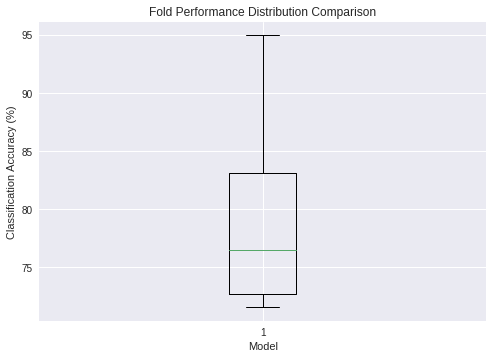

In [30]:
accuracies = []
for user in users:
    accuracies.append(results_six_fold[user]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
     plt.savefig(RESULTS_PATH + "boxplot_6_fold.pdf", format='pdf')

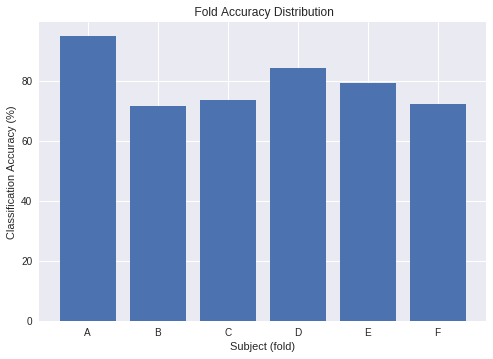

In [31]:
plt.bar(range(len(users)), accuracies, zorder=3)
plt.xticks(range(len(users)), users)
plt.xlabel("Subject (fold)")
plt.ylabel("Classification Accuracy (%)")
plt.title(" Fold Accuracy Distribution")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
    plt.savefig(RESULTS_PATH + "fold_accuracy_distribution_6_fold.pdf", format='pdf')
plt.show()

# Original Model Parameters

In [0]:
SAVE_RESULTS_TEST_C_BASE = False
SAVE_GRAPHS_TEST_C_BASE = True

SAVE_RESULTS_20_BASE = True
SAVE_GRAPHS_20_BASE = True

SAVE_RESULTS_6_FOLD_BASE = True
SAVE_GRAPHS_6_FOLD_BASE = True

In [0]:
nb_epochs = 20
batch_size = 64

In [0]:
def make_base_model():   
    model = Sequential(name="Base")

    model.add(Convolution2D(64, (3, 3), padding='same',
                            input_shape=(1, img_rows, img_cols), activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    
    optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9,
                    nesterov=True)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

## Evaluate on Subject C

In [0]:
data_split = split_train_validation_test("C") # subject c is test subject

# 80% of each subject (excluding C)
train_data = data_split["train_data"]
train_labels = data_split["train_labels"]

# 20% taken from each subject (excluding C)
validation_data = data_split["validation_data"]
validation_labels = data_split["validation_labels"]

# subject C
test_data = data_split["test_data"]
test_labels = data_split["test_labels"]

In [0]:
model = make_base_model()

history = model.fit(train_data, train_labels,
                    batch_size=batch_size,
                    epochs=nb_epochs,
                    shuffle=True, 
                    validation_data=(validation_data, validation_labels),
                    verbose=0)

In [0]:
results = evaluate_model(model, test_data, test_labels, batch_size, target_names)
results["history"] = history.history

7966/7966 [==============================] - 5s 665us/step


## Save Results

In [0]:
if SAVE_RESULTS_TEST_C_BASE:
    with open(RESULTS_PATH + "results_test_c_base.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_test_c_base.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Visualize Results

In [0]:
print("Accuracy:", results["accuracy"]*100)

Accuracy: 78.30780818478533


In [0]:
K.clear_session()

# Evaluating on subset of the data (all subjects) 5-Fold
use 60% for training, 20% for validation (early stopping) and the final 20% for testing.

In [0]:
k_fold_results = {}
number_of_folds = 5
for fold in range(number_of_folds):
    k_fold_results[str(fold)] = {}

In [37]:
average_accuracy = 0
average_loss = 0
for fold in range(number_of_folds):
    test_fold = fold
    validation_fold = (test_fold + 1) % number_of_folds
    print("Fold:", fold)
    
    data_split = split_data(test_fold, validation_fold, number_of_folds)
    
    train_data = data_split["train_data"]
    train_labels = data_split["train_labels"]
    validation_data = data_split["validation_data"]
    validation_labels = data_split["validation_labels"]
    test_data = data_split["test_data"]
    test_labels = data_split["test_labels"]
    
    model = make_base_model()

    history = model.fit(train_data, train_labels,
                        batch_size=batch_size,
                        epochs=nb_epochs,
                        shuffle=True, 
                        validation_data=(validation_data, validation_labels),
                        verbose=0)
    
    results = evaluate_model(model, test_data, test_labels, batch_size, target_names)
    average_accuracy += results["accuracy"]
    average_loss += results["loss"]
    k_fold_results[str(fold)]["accuracy"] = results["accuracy"]
    k_fold_results[str(fold)]["loss"] = results["loss"]
    
k_fold_results["average_accuracy"] = average_accuracy/number_of_folds
k_fold_results["average_loss"] = average_loss/number_of_folds

Fold: 0
8684/8684 [==============================] - 5s 619us/step
Fold: 1
8684/8684 [==============================] - 5s 620us/step
Fold: 2
8684/8684 [==============================] - 5s 620us/step
Fold: 3
8654/8654 [==============================] - 5s 627us/step
Fold: 4
8649/8649 [==============================] - 5s 626us/step


## Save Results

In [0]:
if SAVE_RESULTS_20_BASE:
    with open(RESULTS_PATH + "results_test_20_base.pkl", 'wb') as results_file:
        pickle.dump(k_fold_results, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_test_20_base.pkl", 'rb') as results_file:
    k_fold_results = pickle.load(results_file)

## Visualize Results

### Accuracy Fold Distribution

In [40]:
print("Average Accuracy:", k_fold_results["average_accuracy"]*100)
print("Average Loss:", k_fold_results["average_loss"])

Average Accuracy: 97.10634334520206
Average Loss: 0.11314814092131883


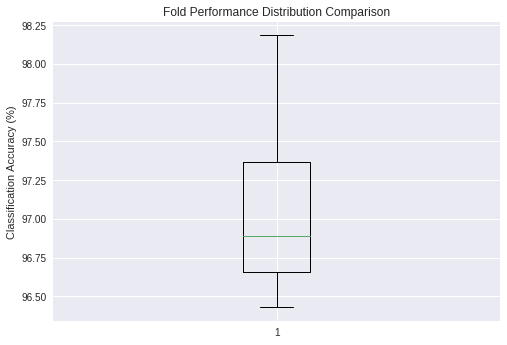

In [41]:
accuracies = []
for fold in range(number_of_folds):
    accuracies.append(k_fold_results[str(fold)]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
# plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_20_BASE:
     plt.savefig(RESULTS_PATH + "boxplot_20_base.pdf", format='pdf')

In [0]:
K.clear_session()

# Six-Fold Cross-Validation
Same method as employed when comparing the original model except this time user all users.

In [0]:
results_six_fold = {}
for user in users:
    results_six_fold[user] = {}

In [46]:
average_accuracy = 0
average_loss = 0
for user in users:
    data_split = split_train_validation_test(user)
    train_data = data_split["train_data"]
    train_labels = data_split["train_labels"]
    validation_data = data_split["validation_data"]
    validation_labels = data_split["validation_labels"]
    test_data = data_split["test_data"]
    test_labels = data_split["test_labels"]
    
    model = make_base_model()

    history = model.fit(train_data, train_labels,
                        batch_size=batch_size,
                        epochs=nb_epochs,
                        shuffle=True, 
                        validation_data=(validation_data, validation_labels),
                        verbose=0)
    
    results = evaluate_model(model, test_data, test_labels, batch_size, target_names)
    average_accuracy += results["accuracy"]
    average_loss += results["loss"]
    results_six_fold[user]["accuracy"] = results["accuracy"]
    results_six_fold[user]["loss"] = results["loss"]

results_six_fold["avg_loss"] = average_loss/len(users)
results_six_fold["avg_acc"] = average_accuracy/len(users)
print("Average Loss:", average_loss/len(users))
print("Average Accuracy:", average_accuracy/len(users))

7966/7966 [==============================] - 5s 620us/step


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


6370/6370 [==============================] - 4s 645us/step
Average Loss: 1.9231071929770376
Average Accuracy: 0.7848044614928873


## Save Results

In [0]:
if SAVE_RESULTS_6_FOLD_BASE:
    with open(RESULTS_PATH + "results_6_fold_base.pkl", 'wb') as results_file:
        pickle.dump(results_six_fold, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_6_fold_base.pkl", 'rb') as results_file:
    results_six_fold = pickle.load(results_file)

## Visualize Results

In [49]:
print("Average Accuracy:", results_six_fold["avg_acc"]*100)
print("Average Loss:", results_six_fold["avg_loss"])

Average Accuracy: 78.48044614928872
Average Loss: 1.9231071929770376


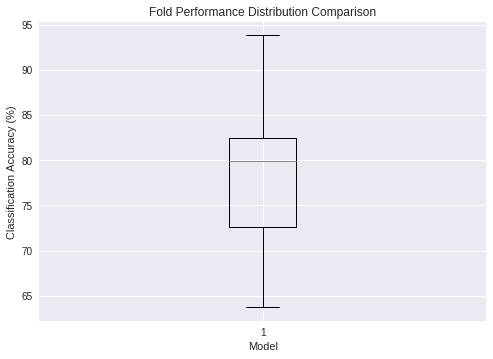

In [50]:
accuracies = []
for user in users:
    accuracies.append(results_six_fold[user]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
     plt.savefig(RESULTS_PATH + "boxplot_6_fold_base.pdf", format='pdf')

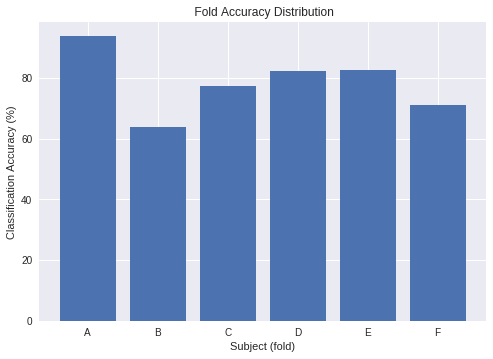

In [51]:
plt.bar(range(len(users)), accuracies, zorder=3)
plt.xticks(range(len(users)), users)
plt.xlabel("Subject (fold)")
plt.ylabel("Classification Accuracy (%)")
plt.title(" Fold Accuracy Distribution")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD_BASE:
    plt.savefig(RESULTS_PATH + "fold_accuracy_distribution_6_fold_base.pdf", format='pdf')
plt.show()